# Evaluation of test year GCM-driven run

In [1]:
import valenspy as vp
from valenspy._utilities import load_yml
from valenspy.preprocessing_tasks.select import select_point
from valenspy.diagnostic_functions import mean_bias, mean_absolute_error, root_mean_square_error, spearman_correlation, perkins_skill_score, time_series_spatial_mean
from valenspy.diagnostic_visualizations import plot_time_series
from pathlib import Path

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd


# define machine name - used for paths of (observational) datasets
machine = 'hortense'

manager = vp.InputManager(machine=machine)


## 0. Pre-defining 

In [2]:
# Define reference datasets
reference = 'ERA5'
test_set = 'EC-Earth'
domain = 'EUR11'
model = "CCLM"

variable = 'tas'
daily_statistic = "mean"

## 1. Functions

In [3]:
def load_data_exp(variable, model, experiment):

    if variable in ['tas','clt', 'clh', 'clm', 'cll']:
        daily_statistic = "mean"
    #    ds_exp = ds_obs.resample(time='1D').mean()

    elif variable == 'pr': 
 
        daily_statistic = "sum"
   #     ds_obs = ds_obs.resample(time='1D').sum()

    elif variable == "tasmax": 
        daily_statistic = "max"
       # ds_obs = ds_obs.resample(time='1D').max()

    ds_mod = manager.load_data(model, [variable], freq="hourly", path_identifiers=[experiment, daily_statistic])


    ds_mod['time'] = ds_mod['time'].dt.floor('D')


    da_exp = ds_mod[variable].compute()

    return da_exp

In [4]:
def plot_point_timeseries(variable: str, ref_dataset: str, experiments: list, point_coord: tuple, point_id:str,  months_to_analyse: list, ax=False): 
        
    # start up input manager
    manager = vp.InputManager(machine=machine)

    if ref_dataset=="ERA5": 
        region_to_load ="europe"
    elif ref_dataset=="ERA5-Land": 
        region_to_load = "belgium"

    # use input manager to load data, defined on settings above
    #ds_obs = manager.load_data(ref_dataset,variable, period=[1995,1995],freq="daily",region=region, path_identifiers = ["-daily-"])
    if ref_dataset == 'ERA5' or ref_dataset== 'ERA5-Land':

        if variable == 'tasmax':        
            variable_to_load = "tas"
            ds_obs = manager.load_data(ref_dataset,variable_to_load, period=[1995,1995],freq="hourly",region=region_to_load)
            ds_obs = ds_obs.resample(time='1D').max().rename({'tas':variable})


        elif variable == "tasmin": 
            variable_to_load = "tas"
            ds_obs = manager.load_data(ref_dataset,variable_to_load, period=[1995,1995],freq="hourly",region=region_to_load)
            ds_obs = ds_obs.resample(time='1D').min().rename({'tas':variable}) 

        elif variable == "pr": 
            ds_obs = manager.load_data(ref_dataset,variable, period=[1995,1995],freq="daily",region=region_to_load, path_identifiers=["sum"])
    
    elif ref_dataset == 'CLIMATE_GRID': 

        # use input manager to load data, defined on settings abov
        ds_obs = manager.load_data(ref_dataset,variable, path_identifiers=['latlon_5km'])

        # select corresponding year
        ds_obs = ds_obs.sel(time = ds_obs.time.dt.year.isin(1995))

        region = 'belgium'

    elif ref_dataset=='EOBS': 

        # use input manager to load data, defined on settings abov
        ds_obs = manager.load_data(ref_dataset,variable, path_identifiers=['0.1deg', 'mean'])
        ds_obs = ds_obs.sel(time = ds_obs.time.dt.year.isin(1995))

    
    # select point 
    ds_obs_point = select_point(ds_obs, point_coord)
    da_obs_point = ds_obs_point[variable].sel(time=ds_obs['time'].dt.month.isin(months_to_analyse))


    # generate path of CCLM output

    # dictorionary to save data arrays of experiments
    d_da_mod_point = {}

    for experiment in experiments: 


        # define the CCLM files for the corresponding variable
        if variable == "tasmax": 
            daily_statistic = "max"
            variable_mod = "tasmax"

        elif variable == "tasmin": 
            daily_statistic = "min"
            variable_mod = "tas"
        elif variable == "pr": 
            daily_statistic = "sum"
            variable_mod =  variable
        else: 
            daily_statistic = "mean"
            variable_mod = variable

        # load data
        ds_mod = manager.load_data(model, [variable_mod], freq="daily", path_identifiers=[experiment, daily_statistic])
        
        if variable =="tasmax" or variable =="tasmin": 
            ds_mod = ds_mod.rename({'tas':variable}) 

        # do selection
        ds_mod_point = select_point(ds_mod, point_coord, rotated_pole=True)

        da_mod_point = ds_mod_point[variable].sel(time=ds_mod['time'].dt.month.isin(months_to_analyse))

        d_da_mod_point[experiment] = da_mod_point

    # do plotting
    # when no ax element is passed, create the figure within the function
    if not ax: 
        fig, ax = plt.subplots(figsize = (7,3))

    if variable == 'pr': 
        da_obs_point = _convert_kg_m2s_to_mm_day(da_obs_point)
    da_obs_point.plot(ax=ax, label = ref_dataset, color='k')

    for experiment in d_da_mod_point: 
        if variable == 'pr': 
            d_da_mod_point[experiment] = _convert_kg_m2s_to_mm_day(d_da_mod_point[experiment])

        d_da_mod_point[experiment].plot(ax=ax, label = experiment, alpha=0.5)

    ax.set_title(' ', loc='center')
    ax.set_title(f"{point_id} ({point_coord[1]}°N,  {point_coord[0]}°E)", loc='right');
    ax.set_title(da_obs_point.attrs['long_name'], loc='left')

    # only add legend if stand-alone figure
    if not ax: 
        ax.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))

        
    return ax


In [5]:
#def split_data_in_years(data):
    

## 2. Running

In [6]:
experiment = "CB2_CCLM_EUR11_EC-Earth_test"
model = "CCLM"
variable = 'tas'
daily_statistic = "mean"
da_exp = manager.load_data(model, [variable], freq="monthly", path_identifiers=[experiment, daily_statistic])
da_exp

File paths found:
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/EUR11_EC-Earth_test/CB2_CCLM_EUR11_EC-Earth_test/T_2M/monthly/T_2M_daymean_199503.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/EUR11_EC-Earth_test/CB2_CCLM_EUR11_EC-Earth_test/T_2M/monthly/T_2M_daymean_199504.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/EUR11_EC-Earth_test/CB2_CCLM_EUR11_EC-Earth_test/T_2M/monthly/T_2M_daymean_199509.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/EUR11_EC-Earth_test/CB2_CCLM_EUR11_EC-Earth_test/T_2M/monthly/T_2M_daymean_199506.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/EUR11_EC-Earth_test/CB2_CCLM_EUR11_EC-Earth_test/T_2M/monthly/T_2M_daymean_199511.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/EUR11_EC-Earth_test/CB2_CCLM_EUR11_EC-Earth_test/T_2M/monthly/T_2M_daymean_199502.nc
/dod

<xarray.Dataset> Size: 284MB
Dimensions:       (time: 365, bnds: 2, rlat: 434, rlon: 446)
Coordinates:
  * time          (time) datetime64[ns] 3kB 1995-01-01T11:30:00 ... 1995-12-3...
    lon           (rlat, rlon) float32 774kB dask.array<chunksize=(434, 446), meta=np.ndarray>
    lat           (rlat, rlon) float32 774kB dask.array<chunksize=(434, 446), meta=np.ndarray>
  * rlon          (rlon) float32 2kB -29.58 -29.48 -29.36 ... 19.15 19.25 19.36
  * rlat          (rlat) float32 2kB -24.58 -24.48 -24.36 ... 22.83 22.93 23.05
    height_2m     float32 4B 2.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds     (time, bnds) datetime64[ns] 6kB dask.array<chunksize=(31, 2), meta=np.ndarray>
    rotated_pole  (time) |S1 365B b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    tas           (time, rlat, rlon) float32 283MB dask.array<chunksize=(31, 434, 446), meta=np.ndarray>
Attributes: (12/18)
    CDI:               Climate Data Interface version 2.3.0 (https://mpimet.m...
    Conventions:       CF-1.4
    source:            cosmo6.00_clm2, int2lm3.0_clm1
    institution:       KU Leuven, Leuven, BELGIUM
    title:             EUR11_NU_TT_EC
    project_id:        CORDEXbe2
    ...                ...
    history:           Tue Nov 19 14:16:43 2024: cdo mergetime daily/T_2M_day...
    frequency:         day
    CDO:               Climate Data Operators version 2.3.0 (https://mpimet.m...
    freq:              monthly
    path_identifiers:  ['CB2_CCLM_EUR11_EC-Earth_test', 'mean']
    dataset:           CCLM

In [7]:
experiment = "CB2_CCLM_EUR11_ERA5_evaluation"
model = "CCLM"

variable = 'tas'
daily_statistic = "mean"
da_eval = manager.load_data(model, [variable], period = [1980,1981], freq="monthly", path_identifiers=[experiment, daily_statistic])
da_eval
# for 3 years: took around 3.5 minutes: 3 for finding folder 20s for loading data

File paths found:
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_EUR11_ERA5_evaluation/CB2_CCLM_EUR11_ERA5_evaluation/T_2M/monthly/T_2M_daymean_198009.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_EUR11_ERA5_evaluation/CB2_CCLM_EUR11_ERA5_evaluation/T_2M/monthly/T_2M_daymean_198003.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_EUR11_ERA5_evaluation/CB2_CCLM_EUR11_ERA5_evaluation/T_2M/monthly/T_2M_daymean_198008.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_EUR11_ERA5_evaluation/CB2_CCLM_EUR11_ERA5_evaluation/T_2M/monthly/T_2M_daymean_198012.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_EUR11_ERA5_evaluation/CB2_CCLM_EUR11_ERA5_evaluation/T_2M/monthly/T_2M_daymean_198010.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_EUR11_ERA5_eval

<xarray.Dataset> Size: 568MB
Dimensions:       (time: 731, bnds: 2, rlat: 434, rlon: 446)
Coordinates:
  * time          (time) datetime64[ns] 6kB 1980-01-01T11:30:00 ... 1981-12-3...
    lon           (rlat, rlon) float32 774kB dask.array<chunksize=(434, 446), meta=np.ndarray>
    lat           (rlat, rlon) float32 774kB dask.array<chunksize=(434, 446), meta=np.ndarray>
  * rlon          (rlon) float32 2kB -29.58 -29.48 -29.36 ... 19.15 19.25 19.36
  * rlat          (rlat) float32 2kB -24.58 -24.48 -24.36 ... 22.83 22.93 23.05
    height_2m     float32 4B 2.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds     (time, bnds) datetime64[ns] 12kB dask.array<chunksize=(31, 2), meta=np.ndarray>
    rotated_pole  (time) |S1 731B b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    tas           (time, rlat, rlon) float32 566MB dask.array<chunksize=(31, 434, 446), meta=np.ndarray>
Attributes: (12/19)
    CDI:               Climate Data Interface version 2.3.0 (https://mpimet.m...
    Conventions:       CF-1.4
    source:            cosmo6.00_clm2, int2lm3.0_clm1
    institution:       KU Leuven, Leuven, BELGIUM
    title:             CB2_CCLM_EUR11_ERA5_evaluation
    project_id:        CORDEXbe2
    ...                ...
    frequency:         day
    CDO:               Climate Data Operators version 2.3.0 (https://mpimet.m...
    freq:              monthly
    path_identifiers:  ['CB2_CCLM_EUR11_ERA5_evaluation', 'mean']
    dataset:           CCLM
    period:            [1980, 1981]

In [8]:
from valenspy.preprocessing_tasks.select import select_region, select_point

# Define the coordinates
d_point_coords = {
    'opwijk'    : (4.18, 50.97), 
    'betrix'    : (5.25, 49.854),
    'north_sea' : (2.465, 51.63),
    'channel'   : (-1.05, 50.14)
}
point_coord = d_point_coords['opwijk']

#da_eval_grid = select_region(da_eval, region = "belgium")

#da_eval_timeseries = time_series_spatial_mean(da_eval_grid)

In [9]:
da_mean_eval = da_eval.mean(dim=["rlat", "rlon"])
da_point_eval = select_point(da_eval, lon_lat_point = point_coord, rotated_pole = True)
da_point_exp = select_point(da_exp, lon_lat_point = point_coord, rotated_pole = True)
da_mean_exp = da_exp.mean(dim = ["rlat", "rlon"])

In [10]:
#ds_year = da_point_eval.sel(time=da_point_eval.time.dt.year.isin([1980]))
#pd.to_datetime(ds_year["time"]).strftime("%m-%d")

## 2. Calculation and visualisation of time series
in this example, the reference data is split up for each year. Each year is plot in a spaghetti plot, where the test year is also included.
Additionally, the P5, P50 and P95 of the reference data is included for every day of every year.

In [11]:
def select_year(da : xr.Dataset, year: int):
    """
    Select single year in dataset

    """

    



In [12]:
import matplotlib.pyplot as plt

In [13]:
def get_spaghetti_GLUE(da_eval: xr.Dataset, da_exp: xr.Dataset, variable: str): 
    """
    Ranks the performance of different models across various metrics based on predefined ranking criteria.

    This function applies custom ranking rules to evaluate the performance of models across different metrics.
    The ranking is based on the following criteria:
    
    - 'Mean Bias' is ranked by its absolute value, with smaller values (closer to zero) ranked higher.
    - 'Spearman Correlation' and 'Perkins Skill Score' are ranked in descending order, meaning higher values (closer to 1) are better.
    - All other metrics are ranked in ascending order, where lower values are better.
    
    The input DataFrame `df` is expected to have the following structure:
    - The first column contains the metric names.
    - Each subsequent column contains the performance values of different models for each metric.
    
    Parameters
    ----------
    df : pandas.DataFrame
        A DataFrame where each row corresponds to a metric, the first column is the metric name, 
        and the subsequent columns contain performance values for different models.
    
    Returns
    -------
    pandas.DataFrame
        A DataFrame where each value is replaced by its rank based on the ranking criteria for the corresponding metric.
        The rows are indexed by the metric names.
    
    """
    plt.figure(figsize = (20,5))
    # Exctract unique years
    years_eval = np.unique(pd.to_datetime(da_eval.time).year)
    years_exp = np.unique(pd.to_datetime(da_exp.time).year)

    # Loop over all years:
    for yr in years_eval:
        ds_year = da_eval.sel(time=da_eval.time.dt.year.isin([yr]))
        ds_year["time"] = pd.to_datetime(ds_year["time"]).strftime("%m-%d")
        da_year = ds_year[variable]
        da_year.plot.scatter(x = "time", y = variable)

    for yr in years_exp:
        ds_year = da_exp.sel(time=da_exp.time.dt.year.isin([yr]))
        ds_year["time"] = pd.to_datetime(ds_year["time"]).strftime("%m-%d")
        da_year = ds_year[variable]
        da_year.plot.line(x = "time", y = variable)
    
   

    return ds_year


In [ ]:
#da_year = ds_year["tas"]
#print(da_year.shape)

NameError: name 'ds_year' is not defined

ValueError: Line plots are for 1- or 2-dimensional DataArrays. Passed DataArray has 3 dimensions

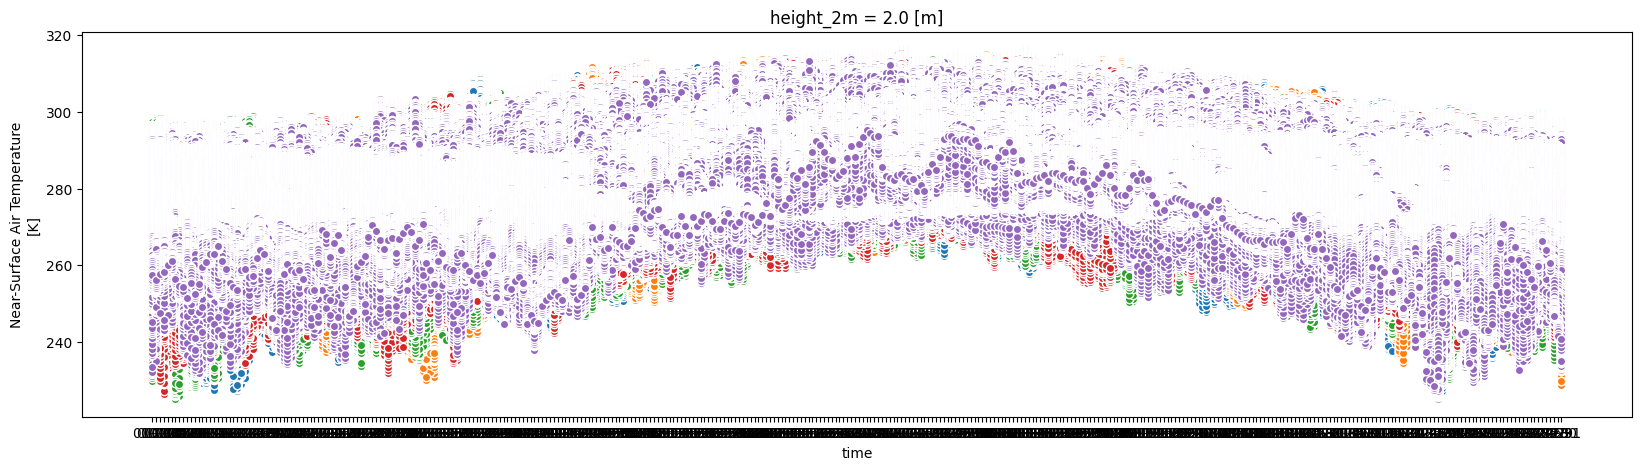

In [ ]:
get_spaghetti_GLUE(da_eval, da_exp, variable = 'tas')

## 3. Calculation of P5, P50, P95 for each year 
In this example, the P5, P50 and P95 for each year are calculated for the reference run and the test year. 